# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import brown
import time

## 1. Load data

In [2]:
nltk.download('brown')


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\aashu\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
corpus = []
sentences = brown.sents(categories="news")
sentences = [[word.lower() for word in sent] for sent in sentences]
corpus = [word for sent in sentences for word in sent]

In [4]:
corpus[0][0]

't'

In [5]:
corpus

['the',
 'fulton',
 'county',
 'grand',
 'jury',
 'said',
 'friday',
 'an',
 'investigation',
 'of',
 "atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 '``',
 'no',
 'evidence',
 "''",
 'that',
 'any',
 'irregularities',
 'took',
 'place',
 '.',
 'the',
 'jury',
 'further',
 'said',
 'in',
 'term-end',
 'presentments',
 'that',
 'the',
 'city',
 'executive',
 'committee',
 ',',
 'which',
 'had',
 'over-all',
 'charge',
 'of',
 'the',
 'election',
 ',',
 '``',
 'deserves',
 'the',
 'praise',
 'and',
 'thanks',
 'of',
 'the',
 'city',
 'of',
 'atlanta',
 "''",
 'for',
 'the',
 'manner',
 'in',
 'which',
 'the',
 'election',
 'was',
 'conducted',
 '.',
 'the',
 'september-october',
 'term',
 'jury',
 'had',
 'been',
 'charged',
 'by',
 'fulton',
 'superior',
 'court',
 'judge',
 'durwood',
 'pye',
 'to',
 'investigate',
 'reports',
 'of',
 'possible',
 '``',
 'irregularities',
 "''",
 'in',
 'the',
 'hard-fought',
 'primary',
 'which',
 'was',
 'won',
 'by',
 'mayor-nominate'

In [6]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(corpus)) #all the words we have in the system - <UNK>

In [7]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['asian']

4107

In [8]:
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

In [9]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'2-and-2'

In [10]:
vocabs

['public',
 'cincinnati',
 'aisle',
 'spectators',
 'elect',
 '2-and-2',
 'mobutu',
 'hoodlum',
 'carpentier',
 '32,000',
 'grinsfelder',
 'reactionary',
 "'52",
 'slice',
 'primary',
 'kas.',
 'get-together',
 'joan',
 'drums',
 "falcons'",
 'wallet',
 'bake',
 'implicit',
 'ton',
 "karns'",
 'paving',
 'dame',
 'rely',
 'examine',
 'theme',
 '11-year-old',
 'mcnair',
 'favoring',
 'undistinguished',
 "department's",
 'eppler',
 'justices',
 'sensitive',
 'nose',
 'rosen',
 'chopper',
 'pad',
 'chaplin',
 'conn.',
 'snodgrass',
 'close',
 'rulers',
 'minorities',
 'turmoil',
 'hurry',
 'outset',
 '.',
 'table',
 'winchester',
 'inflow',
 'fallen',
 'caesar',
 'league',
 'barred',
 'rentals',
 'renting',
 "braves'",
 "russell's",
 'undisputed',
 'plows',
 'more-than-ordinary',
 'keynote',
 'lao',
 'fixing',
 'nichols',
 'monks',
 '61st',
 'smith-colmer',
 'underwriters',
 "gannon's",
 'award',
 'former',
 'fearing',
 'roster',
 'eliminates',
 'trailed',
 'exclaimed',
 'shelters',
 'exp

## 2. Build Co-occurence Matrix X

# Construct the word co-occurrence matrix.
# Each entry represents how often two words
# appear within a context window in the corpus.
# This captures global statistical information.


Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [11]:
from collections import Counter

X_i = Counter((corpus))
X_i

Counter({'the': 6386,
         ',': 5188,
         '.': 4030,
         'of': 2861,
         'and': 2186,
         'to': 2144,
         'a': 2130,
         'in': 2020,
         'for': 969,
         'that': 829,
         'is': 733,
         '``': 732,
         'was': 717,
         "''": 702,
         'on': 691,
         'he': 642,
         'at': 636,
         'with': 567,
         'be': 526,
         'as': 517,
         'by': 504,
         'it': 478,
         'his': 428,
         'said': 406,
         'will': 389,
         'from': 353,
         'are': 330,
         'this': 320,
         ';': 314,
         'an': 311,
         'has': 301,
         '--': 300,
         'but': 283,
         'had': 281,
         'who': 268,
         'they': 267,
         'have': 265,
         'not': 257,
         'mrs.': 253,
         'were': 252,
         'would': 246,
         'which': 245,
         'new': 241,
         'their': 231,
         'one': 213,
         'been': 212,
         'there': 189,
         

In [ ]:
def compute_skipgrams(corpus, window_size=2): #function to compute skip-grams with given window size
    skip_grams = []
    n = len(corpus)
    for i in range(n):
        center = corpus[i]
        start = max(0, i - window_size)
        end = min(n - 1, i + window_size)
        for j in range(start, end + 1):
            if j == i:
                continue
            skip_grams.append((center, corpus[j]))
    return skip_grams

# keep current behavior; adjust window_size to use a larger context
skip_grams = compute_skipgrams(corpus, window_size=2)

skip_grams

[('the', 'fulton'),
 ('the', 'county'),
 ('fulton', 'the'),
 ('fulton', 'county'),
 ('fulton', 'grand'),
 ('county', 'the'),
 ('county', 'fulton'),
 ('county', 'grand'),
 ('county', 'jury'),
 ('grand', 'fulton'),
 ('grand', 'county'),
 ('grand', 'jury'),
 ('grand', 'said'),
 ('jury', 'county'),
 ('jury', 'grand'),
 ('jury', 'said'),
 ('jury', 'friday'),
 ('said', 'grand'),
 ('said', 'jury'),
 ('said', 'friday'),
 ('said', 'an'),
 ('friday', 'jury'),
 ('friday', 'said'),
 ('friday', 'an'),
 ('friday', 'investigation'),
 ('an', 'said'),
 ('an', 'friday'),
 ('an', 'investigation'),
 ('an', 'of'),
 ('investigation', 'friday'),
 ('investigation', 'an'),
 ('investigation', 'of'),
 ('investigation', "atlanta's"),
 ('of', 'an'),
 ('of', 'investigation'),
 ('of', "atlanta's"),
 ('of', 'recent'),
 ("atlanta's", 'investigation'),
 ("atlanta's", 'of'),
 ("atlanta's", 'recent'),
 ("atlanta's", 'primary'),
 ('recent', 'of'),
 ('recent', "atlanta's"),
 ('recent', 'primary'),
 ('recent', 'election'),


In [13]:
X_ik_skipgrams = Counter(skip_grams)
X_ik_skipgrams

Counter({('of', 'the'): 1545,
         ('the', 'of'): 1545,
         ('.', 'the'): 1200,
         ('the', '.'): 1200,
         ('the', ','): 942,
         (',', 'the'): 942,
         (',', ','): 838,
         ('the', 'in'): 724,
         ('in', 'the'): 724,
         (',', 'and'): 632,
         ('and', ','): 632,
         ('to', 'the'): 606,
         ('the', 'to'): 606,
         ('of', ','): 382,
         (',', 'of'): 382,
         ('the', 'and'): 372,
         ('and', 'the'): 372,
         ('a', 'of'): 371,
         ('of', 'a'): 371,
         ('a', ','): 339,
         (',', 'a'): 339,
         (';', ';'): 314,
         (',', 'in'): 310,
         ('in', ','): 310,
         ("''", '.'): 301,
         ('.', "''"): 301,
         ('for', 'the'): 295,
         ('the', 'for'): 295,
         ('on', 'the'): 295,
         ('the', 'on'): 295,
         ('in', '.'): 272,
         ('.', 'in'): 272,
         ('.', ','): 264,
         (',', '.'): 264,
         ('said', ','): 256,
         (',', 'said'

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

<img src = "../figures/glove_weighting_func.png" width=400>

# Define the weighting function used in the GloVe objective.
# This function down-weights very frequent and very rare
# word pairs to stabilize training, following the GloVe paper.


In [ ]:
def weighting(w_i, w_j, X_ik): #weighting function as per GloVe paper
    
    #check whether the co-occurences between w_i and w_j is available
    try:
        x_ij = X_ik[(w_i, w_j)]
        #if not exist, then set to 1 "laplace smoothing"
    except:
        x_ij = 1
        
    #set xmax
    x_max = 100
    #set alpha
    alpha = 0.75
    
    #if co-ocurrence does not exceeed xmax, then just multiply with some alpha
    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    #otherwise, set to 1
    else:
        result = 1
    
    return result

In [15]:
# Build only observed co-occurrences to avoid O(|V|^2) memory
X_ik = {pair: co + 1 for pair, co in X_ik_skipgrams.items()}  # Laplace smoothing

# Precompute weightings only for observed pairs
x_max = 100
alpha = 0.75
weighting_dic = {
    pair: ((x_ij / x_max) ** alpha if x_ij < x_max else 1.0)
    for pair, x_ij in X_ik.items()
}


## 3. Prepare train data

In [ ]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic): #function to generate random batch of input, label, co-occurence and weighting
    
    random_inputs, random_labels, random_coocs, random_weightings = [], [], [], []
    
    #convert our skipgrams to id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly choose indexes based on batch size
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False)
    
    #get the random input and labels
    for index in random_index:
        random_inputs.append([skip_grams_id[index][0]])
        random_labels.append([skip_grams_id[index][1]])
        #coocs
        pair = skip_grams[index] #e.g., ('banana', 'fruit')
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
    
        #weightings
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [17]:
batch_size = 8 #2
x, y, cooc, weighting = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

In [18]:
x

array([[ 6858],
       [ 6215],
       [ 4423],
       [ 7495],
       [10652],
       [ 8948],
       [ 6599],
       [ 6864]])

In [19]:
y

array([[12104],
       [ 1714],
       [ 2634],
       [12492],
       [ 1335],
       [ 9169],
       [  710],
       [ 7029]])

In [20]:
cooc

array([[0.69314718],
       [0.69314718],
       [0.69314718],
       [4.06044301],
       [0.69314718],
       [0.69314718],
       [0.69314718],
       [0.69314718]])

In [21]:
weighting

array([[0.05318296],
       [0.05318296],
       [0.05318296],
       [0.66461631],
       [0.05318296],
       [0.05318296],
       [0.05318296],
       [0.05318296]])

## 4. Model

<img src ="../figures/glove.png" width=400>

In [22]:
class Glove(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Glove, self).__init__()
        self.center_embedding  = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)
        
        self.center_bias       = nn.Embedding(voc_size, 1) 
        self.outside_bias      = nn.Embedding(voc_size, 1)
    
    def forward(self, center, outside, coocs, weighting):
        center_embeds  = self.center_embedding(center) #(batch_size, 1, emb_size)
        outside_embeds = self.outside_embedding(outside) #(batch_size, 1, emb_size)
        
        center_bias    = self.center_bias(center).squeeze(1)
        target_bias    = self.outside_bias(outside).squeeze(1)
        
        inner_product  = outside_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1)
        
        loss = weighting * torch.pow(inner_product + center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [23]:
#test our system
voc_size = len(vocabs)
emb_size = 8
model = Glove(voc_size, emb_size)

In [24]:
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)
cooc_tensor = torch.FloatTensor(cooc)
weighting_tensor = torch.FloatTensor(weighting)

In [25]:
loss = model(x_tensor, y_tensor, cooc_tensor, weighting_tensor)

In [26]:
loss

tensor(3.7836, grad_fn=<SumBackward0>)

## 5. Training

In [27]:
batch_size     = 8 # mini-batch size
embedding_size = 8 #so we can later plot
model          = Glove(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
# Training
num_epochs = 1000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    # forward and average loss 
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    loss = loss / input_batch.size(0)

    # inline logging for training loss and time
    print(f"Epoch {epoch + 1}/{num_epochs} - loss: {loss.detach().item():.6f} - time: {time.time() - start:.2f}s")
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch 1/1000 - loss: 0.898920 - time: 0.18s
Epoch 2/1000 - loss: 2.502121 - time: 0.20s
Epoch 3/1000 - loss: 4.145720 - time: 0.21s
Epoch 4/1000 - loss: 11.357151 - time: 0.21s
Epoch 5/1000 - loss: 1.161442 - time: 0.23s
Epoch 6/1000 - loss: 9.355363 - time: 0.21s
Epoch 7/1000 - loss: 20.303984 - time: 0.23s
Epoch 8/1000 - loss: 1.654954 - time: 0.23s
Epoch 9/1000 - loss: 16.337446 - time: 0.22s
Epoch 10/1000 - loss: 1.500936 - time: 0.23s
Epoch 11/1000 - loss: 0.924583 - time: 0.23s
Epoch 12/1000 - loss: 0.677641 - time: 0.21s
Epoch 13/1000 - loss: 0.413813 - time: 0.21s
Epoch 14/1000 - loss: 2.564095 - time: 0.23s
Epoch 15/1000 - loss: 0.533697 - time: 0.21s
Epoch 16/1000 - loss: 4.389553 - time: 0.22s
Epoch 17/1000 - loss: 16.560942 - time: 0.22s
Epoch 18/1000 - loss: 10.435654 - time: 0.21s
Epoch 19/1000 - loss: 3.805072 - time: 0.22s
Epoch 20/1000 - loss: 0.697476 - time: 0.17s
Epoch 21/1000 - loss: 4.412555 - time: 0.20s
Epoch 22/1000 - loss: 2.156850 - time: 0.21s
Epoch 23/1000 

## 6. Plotting the embeddings

In [30]:
#list of vocabs
vocabs[:10]

['public',
 'cincinnati',
 'aisle',
 'spectators',
 'elect',
 '2-and-2',
 'mobutu',
 'hoodlum',
 'carpentier',
 '32,000']

In [31]:
word = vocabs[0]

In [32]:
#numericalization
id = word2index[word]
id

0

In [33]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [34]:
#get the embedding by averaging
v_embed = model.center_embedding(id_tensor)
u_embed = model.outside_embedding(id_tensor)

v_embed, u_embed

(tensor([[ 0.6404, -0.7182,  1.2075,  1.8415, -1.0227, -0.4715,  1.1835,  0.8187]],
        grad_fn=<EmbeddingBackward0>),
 tensor([[-0.2483, -1.0262,  1.1419, -0.3441, -0.4363,  0.9724, -0.5438, -1.9209]],
        grad_fn=<EmbeddingBackward0>))

In [35]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed

tensor([[ 0.1960, -0.8722,  1.1747,  0.7487, -0.7295,  0.2504,  0.3198, -0.5511]],
       grad_fn=<DivBackward0>)

In [36]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.center_embedding(id_tensor)
    u_embed = model.outside_embedding(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

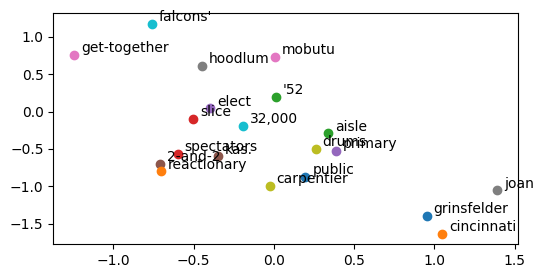

In [37]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [38]:
vocabs

['public',
 'cincinnati',
 'aisle',
 'spectators',
 'elect',
 '2-and-2',
 'mobutu',
 'hoodlum',
 'carpentier',
 '32,000',
 'grinsfelder',
 'reactionary',
 "'52",
 'slice',
 'primary',
 'kas.',
 'get-together',
 'joan',
 'drums',
 "falcons'",
 'wallet',
 'bake',
 'implicit',
 'ton',
 "karns'",
 'paving',
 'dame',
 'rely',
 'examine',
 'theme',
 '11-year-old',
 'mcnair',
 'favoring',
 'undistinguished',
 "department's",
 'eppler',
 'justices',
 'sensitive',
 'nose',
 'rosen',
 'chopper',
 'pad',
 'chaplin',
 'conn.',
 'snodgrass',
 'close',
 'rulers',
 'minorities',
 'turmoil',
 'hurry',
 'outset',
 '.',
 'table',
 'winchester',
 'inflow',
 'fallen',
 'caesar',
 'league',
 'barred',
 'rentals',
 'renting',
 "braves'",
 "russell's",
 'undisputed',
 'plows',
 'more-than-ordinary',
 'keynote',
 'lao',
 'fixing',
 'nichols',
 'monks',
 '61st',
 'smith-colmer',
 'underwriters',
 "gannon's",
 'award',
 'former',
 'fearing',
 'roster',
 'eliminates',
 'trailed',
 'exclaimed',
 'shelters',
 'exp

In [42]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# Step 1: build final embedding matrix
W = (model.center_embedding.weight.detach().cpu().numpy() +
     model.outside_embedding.weight.detach().cpu().numpy()) / 2

# Normalize embeddings for fast cosine similarity
W_norm = W / np.linalg.norm(W, axis=1, keepdims=True)



def get_vector(word):
    if word not in word2index:
        return None
    return W_norm[word2index[word]] 


In [44]:
index2word = {idx: word for word, idx in word2index.items()}
def predict_analogy(a, b, c, W_norm, word2index, index2word):
    if a not in word2index or b not in word2index or c not in word2index:
        return None

    va = W_norm[word2index[a]]
    vb = W_norm[word2index[b]]
    vc = W_norm[word2index[c]]

    # Vector arithmetic: b - a + c
    target = vb - va + vc
    target = target / np.linalg.norm(target)

    # Cosine similarity with ALL words at once
    similarities = np.dot(W_norm, target)

    # Exclude input words
    for w in (a, b, c):
        similarities[word2index[w]] = -1

    best_index = np.argmax(similarities)
    return index2word[best_index]



In [45]:
predict_analogy("banana", "fruit", "apple", W, word2index, index2word)


In [49]:

def evaluate_analogies(file_path, W_norm, word2index, index2word):
    total = 0
    correct = 0

    with open(file_path, "r") as f:
        for line in f:
            words = line.strip().split()
            if len(words) != 4:
                continue

            a, b, c, d = words
            prediction = predict_analogy(
                a, b, c, W_norm, word2index, index2word
            )


            total += 1
            if prediction == d:
                correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total


Semantic and Syntactic Test

In [50]:
semantic_acc, sem_correct, sem_total = evaluate_analogies(
    "country-capital.txt",
    W,
    word2index,
    index2word
)


In [51]:
syntactic_acc, syn_correct, syn_total = evaluate_analogies(
    "past-tense.txt",
    W,
    word2index,
    index2word
)

print(f"Semantic accuracy (capital-common-countries): {semantic_acc:.4f} ({sem_correct}/{sem_total})")
print(f"Syntactic accuracy (past-tense): {syntactic_acc:.4f} ({syn_correct}/{syn_total})")


Semantic accuracy (capital-common-countries): 0.0000 (0/5030)
Syntactic accuracy (past-tense): 0.0000 (0/1560)


In [52]:
import pandas as pd
similarity_df = pd.read_csv("combined.csv")
similarity_df.head()

,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


In [53]:
model_scores = []
human_scores = []
skipped = 0

for _, row in similarity_df.iterrows():
    w1 = row["Word 1"]
    w2 = row["Word 2"]
    human_score = row["Human (mean)"]

    if w1 not in word2index or w2 not in word2index:
        skipped += 1
        continue

    v1 = W_norm[word2index[w1]]
    v2 = W_norm[word2index[w2]]

    model_sim = np.dot(v1, v2)  # cosine similarity

    model_scores.append(model_sim)
    human_scores.append(human_score)

print(f"Used pairs: {len(model_scores)}")
print(f"Skipped OOV pairs: {skipped}")


Used pairs: 197
Skipped OOV pairs: 156


Spearman Similarity Test

In [54]:

from scipy.stats import spearmanr

correlation, p_value = spearmanr(model_scores, human_scores)

print(f"Spearman correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")


Spearman correlation: -0.0000
P-value: 9.9987e-01


In [55]:
print("Example comparisons:")
for i in range(5):
    print(
        similarity_df.iloc[i, 0],
        similarity_df.iloc[i, 1],
        "Human:", human_scores[i],
        "Model:", round(model_scores[i], 3)
    )



Example comparisons:
love sex Human: 6.77 Model: 0.075
tiger cat Human: 7.46 Model: 0.273
tiger tiger Human: 5.77 Model: -0.236
book paper Human: 6.31 Model: 0.036
computer keyboard Human: 7.5 Model: -0.064


In [56]:
start_time = time.time()
for i in range(5, 10):
    print(
        similarity_df.iloc[i, 0],
        similarity_df.iloc[i, 1],
        "Human:", human_scores[i],
        "Model:", round(model_scores[i], 3)
    )
end_time = time.time()
print(f"Time taken for second batch: {end_time - start_time:.4f} seconds")

computer internet Human: 6.77 Model: -0.207
plane car Human: 6.19 Model: -0.25
train car Human: 7.0 Model: 0.024
telephone communication Human: 6.62 Model: 0.435
television radio Human: 6.81 Model: -0.119
Time taken for second batch: 0.0010 seconds


In [63]:
import pandas as pd

results = {
    "Model": ["GloVe"],
    "Window Size": ["2"],
    "Training Loss": [loss.item()],
    "Training time": [end - start],
    "Syntactic Accuracy": [syntactic_acc],
    "Semantic accuracy": [semantic_acc]
}

df_glove = pd.DataFrame(results)
df_glove


,Model,Window Size,Training Loss,Training time,Syntactic Accuracy,Semantic accuracy
0,GloVe,2,3.249294,0.142007,0.0,0.0
